<a href="https://colab.research.google.com/github/thamyrissacamoto/MarvelAPI/blob/dev/client.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

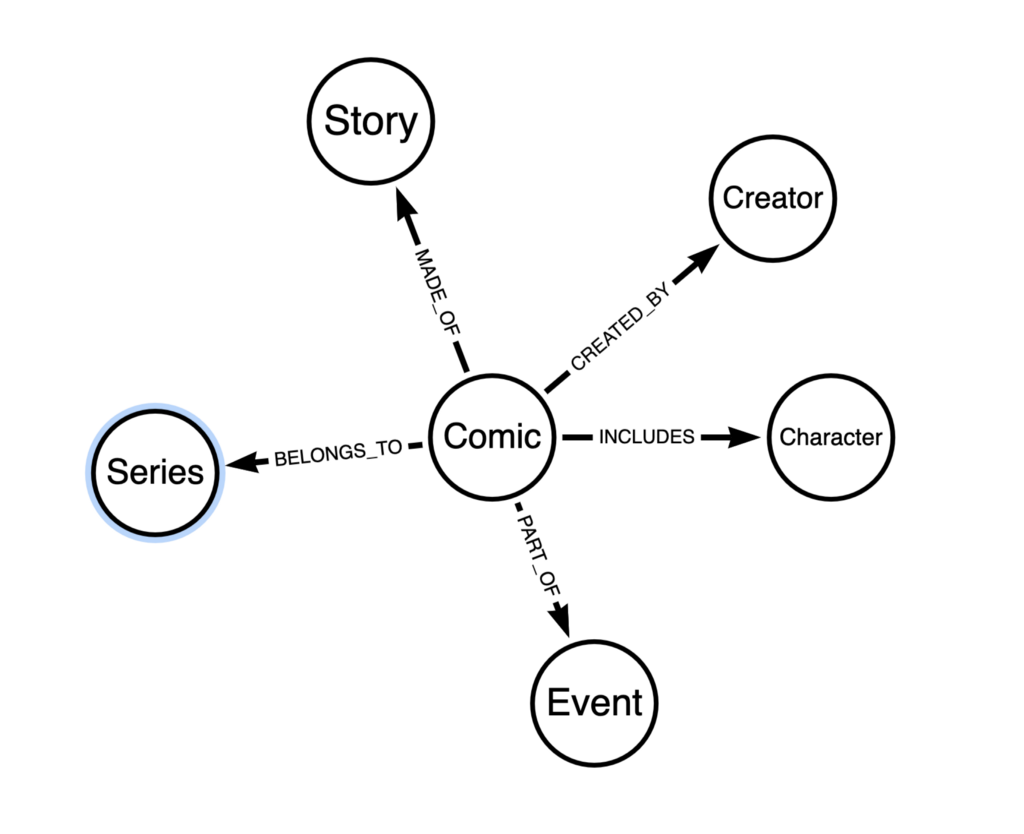

In [ ]:
!pip install dotenv

In [2]:
import hashlib
import time
import requests
from google.colab import userdata
import pandas as pd
from tqdm import tqdm
import os
from dotenv import load_dotenv

In [3]:
BASE_URL = "https://gateway.marvel.com/v1/public/"

# load_dotenv()
# PUBLIC_KEY = os.getenv("public_key")
# PRIVATE_KEY = os.getenv("private_key")

PUBLIC_KEY = userdata.get('public_key')
PRIVATE_KEY = userdata.get('private_key')

def get_auth():
    """
    Gera os parâmetros de autenticação.

    Retorna:
        dict: Um dicionário contendo os campos 'ts', 'apikey' e 'hash'.
    """
    ts = str(time.time())
    to_hash = ts + PRIVATE_KEY + PUBLIC_KEY
    hash_result = hashlib.md5(to_hash.encode()).hexdigest()
    return {
        "ts": ts,
        "apikey": PUBLIC_KEY,
        "hash": hash_result
    }


In [4]:
etag_cache = {}

In [5]:
def marvel_request(endpoint, params_extra={}):
    """
    Faz uma requisição com suporte a ETag.

    Parâmetros:
        endpoint (str): Caminho para requisição.
        params_extra (dict): Parâmetros adicionais da requisição.

    Retorna:
        dict: Dados retornados pela API ou None em caso de erro.
    """
    url = BASE_URL + endpoint
    auth_params = get_auth()
    params = auth_params.copy()
    params.update(params_extra)

    param_tuple = tuple(sorted(params_extra.items()))
    cache_key = f"{endpoint}_{tuple(sorted(params_extra.items()))}"

    headers = {}

    if cache_key in etag_cache:
        headers["If-None-Match"] = etag_cache[cache_key]["etag"]

    try:
        response = requests.get(url, params=params, headers=headers, timeout=10)

        if response.status_code == 304:
            print(f"Dados não modificados (304)")
            return etag_cache[cache_key]["data"]

        elif response.status_code == 200:
            etag = response.headers.get("etag")
            data = response.json()

            etag_cache[cache_key] = {
                "etag": etag,
                "data": data
            }
            return data

        else:
            print(f"{response.status_code} - {response.text}")
            return None

    except requests.exceptions.Timeout:
        print(f"Requisição excedeu o tempo limite: {url}")
        return None

    except requests.exceptions.RequestException as e:
        print(f"Erro ao acessar {url}: {e}")
        return None

In [6]:
def get_all_data(endpoint):
    """
    Extrai todos os dados de um endpoint da API e salva em um arquivo CSV.

    Parâmetros:
        endpoint (str): Caminho para requisição.

    Retorna:
        pd.DataFrame: DataFrame com todos os resultados extraídos.
    """
    limit = 100
    offset = 0
    all_results = []

    while True:
        params = {"limit": limit, "offset": offset}
        response = marvel_request(endpoint, params)
        time.sleep(0.2)

        if not response or "data" not in response:
            break

        data = response["data"]
        results_page = data.get("results", [])
        total = data.get("total", 0)

        all_results.extend(results_page)

        offset += limit
        if offset >= total or not results_page:
            break

    df = pd.json_normalize(all_results)
    df.to_csv(f"{endpoint}.csv", index=False)
    return df

In [7]:
def get_relationships(endpoint, ids, relationships):
    """
    Para cada ID do endpoint, busca os relacionamentos definidos,
    usando ETag e salva em CSV.

    Parâmetros:
        endpoint (str): Caminho para requisição.
        ids (list): Lista de IDs a serem pesquisados.
        relationships (list): Lista de relacionamentos.

    Retorna:
        pd.DataFrame: DataFrame com IDs e os relacionamentos relacionados.
    """
    results = []

    for item_id in tqdm(ids, desc=f"Buscando relacionamentos de {endpoint}"):
        item_data = {"id": item_id}

        for rel in relationships:
            rel_url = f"{endpoint}/{item_id}/{rel}"
            all_rel_ids = []
            offset = 0
            limit = 100

            while True:
                params = {"limit": limit, "offset": offset}
                rel_response = marvel_request(rel_url, params)
                time.sleep(0.2)

                if not rel_response or "data" not in rel_response:
                    break

                results_page = rel_response["data"].get("results", [])
                total = rel_response["data"].get("total", 0)

                all_rel_ids.extend([r["id"] for r in results_page])
                offset += limit

                if offset >= total or not results_page:
                    break

            item_data[f"{rel}_ids"] = all_rel_ids

        results.append(item_data)

    df = pd.DataFrame(results)
    df.to_csv(f"{endpoint}_ids_relationships.csv", index=False)
    return df

In [ ]:
endpoints = ["characters"]

for ep in endpoints:
    print(f"\nExtraindo dados de: {ep}")
    get_all_data(ep)


df = get_all_data("characters")
all_character = df['id'].tolist()

# ids = [1009610, 1009726, 1009718, 1009368, 1009220, 1009165, 1009664, 1009351, 1009299, 1009262]
df_rels = get_relationships("characters", all_character, relationships=["events"])
